# A Netflix Tour of Data Science - Film suggestion by diffusion on graphs
# Main notebook

### Students:

    * Team     : 17
    * Students : Edwige Avignon, Kenneth Nguyen, Pierre Fourcade  
    * Dataset  : Kaggle dataset - Films and Crew

### Introduction:

Nowadays, most of the streaming platforms propose a targeted service that suggests you the films/series that you might enjoy according to the films/series that you have already watched. For instance Netflix proposes this kind of service and their proposals are often very accurate.
Imagine now that you are a modest student, you cannot afford those services but you do not want to spend your Saturday evening looking for a film instead of watching it. However, you have followed a course in Data Science and you wonder if you can finally get rid of this time loss by imagining a system that would target for you the films you would like.
One may think that the scenario, the performance of the actors and the depth of the story are important criteria to know if someone is going to enjoy the film or not... but then, realizing that “Furious 7” was ranked 7, “Transformers: Dark of the Moon” was ranked 20 in a [list of highest-grossing films](https://en.wikipedia.org/wiki/List_of_highest-grossing_films), we wondered if simpler criteria (such as the cast, the crew, the genre, the budget, the advertising...) were not more critical in the valuation of the film. The main idea that we are going to use here is that if you liked (resp. disliked) a film with a particular cast, crew, genre, you might also like (resp. dislike) a film presenting similar features.

To get an idea of how are the similarities between every films we can use graphs. Indeed when we are building graphs we are making strong, weak or no connections between nodes to represent how similar two nodes on the graph are. Those connections are the edges and the force of those connections are the weights. Thus we can build several adjacency matrices representing the similarities of the films (nodes) for different features. From here we want to analyse and predict the likings of someone called “user”. A user can only inform us if he liked or not a film with a vote between 0 and 10 (10 being that he loved the film). Then to predict the likings of this user, our idea is to combine the graph with the signal representing the average of the vote given by all users, the signal representing our particular user votes. Our user has only seen a few films and his votes propagate to the closest neighbours using diffusion with a heat-kernel slightly modified to make sense in this subject. This would create a personalized signal for this user based on the average rating of the others (because it would takes too long for the users to watch enough films to have relevant proposals).

### Objectives:

Here are the different objectives that we have for this project:

- Build different weighted adjacency matrices for the features that we are considering representing correctly the similarity between the movies.
- Model a diffusion of a single node on a graph while considering a base signal already present on the graph.
- Analyse the results and observe them on Gephi.
- Conclude on the model we have chosen.

### Organization:

This project is cut into different notebooks.

This notebook correspond to the application of our model to the different graph we have built.
If the exports haven't been made the following notebooks must be ran in the following order:

1. The notebook "Adjacency_Cast". It corresponds to the notebook used to create an adjacency matrix from the cast.
2. The notebook "Adjacency_First_Role". It corresponds to the notebook used to create an adjacency matrix from the first roles (cast).
3. The notebook "Adjacency_Genres". It corresponds to the notebook used to create an adjacency matrix from the genres.
4. The notebook "Adjacency_Crew". It corresponds to the notebook used to create an adjacency matrix from the crew.
5. The notebook "Signal_Vote_Average" corresponds to the notebook used to extract the base signal that we are going to use on the different graphs, corresponding to the average vote of the movies.

More informations on the different notebooks are available in the notebook in question.

The dataset and different exports made in the project can be found in the folder "Dataset_Exports".

## 0 - Libraries, database and usefull functions

First of all we import several libraries that we will use in this notebook and the dataset gathering the informations on the credits and the movies of 4803 movies.
We also define several functions that will be usefull in this notebook.

In [1]:
# Libraries:

import numpy as np
import pandas as pd
import pygsp as pg
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Database:

credits = pd.read_csv('Dataset_Exports/tmdb_5000_credits.csv')
movies = pd.read_csv('Dataset_Exports/tmdb_5000_movies.csv')

In [3]:
def Signal_Informations(Graph, Signal, Tau):
    
    '''
    
    Function to plot the GFT of the signal for the graph considered and to evaluate if the parameter Tau for the
    heat diffusion is correct for the signal.
    ------------------------------------------------------
    Parameters:
    ----------
    Graph  : Graph that needs to be considered. The graph needs to be computed with PyGSP.
    Signal : Base signal of the graph.
    Tau    : Parameters for the heat diffusion.
    ------------------------------------------------------
    Return:
    ------
    Plot two curves: one for the GFT of the signal and the other for the filter in the spectral domain.
    
    '''    
    
    Graph.compute_laplacian(lap_type='combinatorial')
    Graph.compute_fourier_basis()
    
    GFTSignal   = Graph.gft(Signal)
    
    Heat_filter = pg.filters.Heat(Graph, Tau)
    y           = Heat_filter.evaluate(Graph.e)
     
    plt.figure('Informations', figsize=(10,5))
    plt.title('Plot of the GFT and the Heat-kernel')
    plt.xlabel('Eigenvalues')
    plt.plot(Graph.e, abs(GFTSignal), 'b')
    plt.plot(Graph.e, y[0]*np.max(abs(GFTSignal)), 'r')
    plt.legend(['abs(GFT(Signal))','Heat-kernel'])

In [4]:
def Heat_Diffusion_Exports(Graph, Signal, Node, Source_type, Tau):
    
    '''
    
    Function to compute the heat diffusion in the considered graph and its influence on the base 
    signal. This function only considers that the user can vote 0 or 10.
    ------------------------------------------------------
    Parameters:
    ----------
    Graph       : Graph that needs to be considered. The graph needs to be computed with PyGSP.
    Signal      : Base signal of the graph.
    Node        : Id of the node on the graph that is considered for the diffusion.
    Source_type : 'Hot' or 'Cold'. 'Hot' to specify that the node considered will "warm" the graph and 'Cold' to 
                  specify that the node considered "cool" the graph.
    Tau         : Parameter for the heat diffusion.
    ------------------------------------------------------
    Return:
    ------
    Diff_signal : Values of the node diffused in the graph and modified to match the base signal.
    New_signal  : Values of the new signal that considered the heat diffusion of the node.

    '''
    
    Graph.compute_laplacian(lap_type='combinatorial')
    Graph.compute_fourier_basis()
    
    Diff_dirac       = np.zeros(len(Signal))
    Diff_dirac[Node] = 10
    
    New_signal  = np.zeros(len(Signal))
    
    Heat_filter = pg.filters.Heat(Graph, Tau)
    Diff_signal = Heat_filter.filter(Diff_dirac, method = 'exact')
    Diff_signal = Diff_signal * (10 / np.max(Diff_signal))
    
    if Source_type == 'Hot':
        for i in range (len(New_signal)):
            if i == Node:
                New_signal[i] = 10
            else:
                if Diff_signal[i] <= Signal[i]:
                    New_signal[i]  = Signal[i]
                else:
                    New_signal[i]  = (Diff_signal[i] + Signal[i]) / 2
    
    elif Source_type == 'Cold':
        Diff_signal = 10 - Diff_signal
        for i in range (len(New_signal)):
            if i == Node:
                New_signal[i] = 0
            else:
                if Diff_signal[i] >= Signal[i]:
                    New_signal[i]  = Signal[i]
                else:
                    New_signal[i]  = (Diff_signal[i] + Signal[i]) / 2
    
    else:
        print("Error: the parameter Source_type is not accepted. Specify 'Hot' or 'Cold'.")
        
    return(Diff_signal, New_signal) 

In [5]:
def Bin_10_Signal(Signal):

    '''
    
    Function to place into 10 bins the values of the signal.
    ------------------------------------------------------
    Parameters:
    ----------
    Signal     : Signal to place into the 10 bins.
    ------------------------------------------------------
    Return:
    ------
    Bin_signal : Signal with the values modified according to the 10 bins.
    
    '''
    
    Bin_signal = np.zeros(len(Signal))
    
    for i in range (len(Bin_signal)):
        if Signal[i] < 0.5:
            Bin_signal[i] = 0
        elif Signal[i] >= 0.5 and Signal[i] < 1.5:
            Bin_signal[i] = 1
        elif Signal[i] >= 1.5 and Signal[i] < 2.5:
            Bin_signal[i] = 2
        elif Signal[i] >= 2.5 and Signal[i] < 3.5:
            Bin_signal[i] = 3
        elif Signal[i] >= 3.5 and Signal[i] < 4.5:
            Bin_signal[i] = 4
        elif Signal[i] >= 4.5 and Signal[i] < 5.5:
            Bin_signal[i] = 5
        elif Signal[i] >= 5.5 and Signal[i] < 6.5:
            Bin_signal[i] = 6
        elif Signal[i] >= 6.5 and Signal[i] < 7.5:
            Bin_signal[i] = 7
        elif Signal[i] >= 7.5 and Signal[i] < 8.5:
            Bin_signal[i] = 8
        elif Signal[i] >= 8.5 and Signal[i] < 9.5:
            Bin_signal[i] = 9
        else:
            Bin_signal[i] = 10
            
    return(Bin_signal)

In [6]:
def Fill_Dataframe(Graph, Base_signal, Nodes, Source_types, Tau, Dataframe):
    
    '''
    
    Function to perform a series of diffusion and to fill the Dataframe.
    ------------------------------------------------------
    Parameters:
    ----------
    Graph       : Graph that needs to be considered. The graph needs to be computed with PyGSP.
    Signal      : Base signal of the graph.
    Nodes       : Array of the Id of the nodes on the graph that are considered for the diffusion, in order.
    Source_types: Array of source types for each node in the same order: 'Hot' or 'Cold'. 
                  'Hot' to specify that the node considered will "warm" the graph and 'Cold' to specify that the 
                  node considered "cool" the graph.
    Tau         : Parameter for the heat diffusion.
    ------------------------------------------------------
    Return:
    ------
    Dataframe   : The complete dataframe gathering each step of the function.
    Final_signal: The new signal on the graph taking into account the diffusion of all the movies considered.
    
    '''
    
    Signal = Base_signal
    
    for i in range(len(Nodes)):
        
        Diff_signal, New_signal = Heat_Diffusion_Exports(Graph, Signal, Nodes[i], Source_types[i], Tau)
        
        Diff_signal_bin = Bin_10_Signal(Diff_signal)
        New_signal_bin  = Bin_10_Signal(New_signal)
        
        Dataframe['diff_signal_node{}'.format(Nodes[i])] = Diff_signal_bin
        Dataframe['vote_average{}'.format(i+1)] = New_signal_bin
        
        Signal = New_signal
        
    Final_Signal = Signal
        
    return(Dataframe, Final_Signal)

In [96]:
def Find_Movie(Signal, Nodes):
    
    '''
    
    Function to find some of the movies most suited for the user according to the signal.
    ------------------------------------------------------
    Parameters:
    ----------
    Signal         : Signal corresponding to the vote for the user.
    Nodes          : Id of the movies already seen by the user that we can't propose.
    ------------------------------------------------------
    Return:
    ------
    Proposed_movie : Movies with the best vote according to the signal. 
    
    '''
    
    Place_best_votes = []
    Move             = 0
    Signal_sorted    = np.sort(Signal)   
    
    while len(Place_best_votes) < 20:
        vote = Signal_sorted[len(Signal_sorted)-(Move+1)]
        for i in range (len(Signal)):
            if Signal[i] == vote:
                Considered = False
                for j in range (len(Nodes)):
                    if Nodes[j] == i:
                        Considered = True
                if Considered == False:
                    for k in range (len(Place_best_votes)):
                        if Place_best_votes[k] == i:
                            Considered = True
                if Considered == False:
                    Place_best_votes.append(i)
        Move = Move + 1
                    
    print('You might want to take a look at the following movies:') 
    for l in range (20):
        print('- {}'.format(movies.title[Place_best_votes[l]]))

The different graph needed in this notebook are computed in the other notebooks. More informations in the section "Organization".

## 1 - Adapted diffusion on the graphs

To influence the other nodes and to make a graph specific to one user we want to use diffusion and more precisely the heat-kernel.

As we have built graphs with the goal to make close two films similar. If we change the vote of a node we want it to diffuse its note, to influence the films similar to it meaning its close neighbours. Then, we want to create a diffusion by closest neighbours. This is an approach that is suited to use the heat-kernel as it simulate the heat diffusion, a diffusion by closest neighbours.

However, to diffuse a single vote on a graph we have to consider a Dirac of this vote and then apply the heat-kernel to this Dirac (in the spectral domain). The problem is that we are considering a base signal: the average vote. This signal is the starting point, it is the notes we take into account until the user modifies them. It wouldn’t be interesting to build a signal from the start in our case. But this means that we cannot just change the vote of one node on the signal and apply the heat-kernel: we would just diffuse every node in it and it would be meaningless.
Then, we need to take into account the diffusion by the heat-kernel of a single node in a base signal already present. For that we need to adapt the diffusion.

In this project we will only consider that the user likes a movie and vote 10 or dislikes and vote 0. Thus we have two different cases of diffusion one with a source heating-up the grah (10) and the other cooling down the graph.

If we consider the 10, here is the how we adapt the diffusion:
1. The vote of the user creates a Dirac of 10 in the position of the considered node.
2. We filter this dirac with the heat-kernel (spectral domain). Then we have a profile of how the node diffuse in the graph.
3. We multiply the values of this diffused Dirac so that the highest value is equal to 10.
4. Then to take into account the base signal and the diffused Dirac we create a new signal which is the mean terms by terms of the base signal and the diffused Dirac.
5. However, in the case of films, placing a heat source can't cool the other nodes (liking a type of films doesn’t mean we will dislike the other kinds) so the new signal only take the means if it is superior to the vote of the base signal.
6. Finally, the votes of the user are fixed and cannot be changed unlike in a classical heat diffusion where the heat source would have become colder as it gave its heat to its neighbours.

If we consider the 0, the staps are basically the same but we are cooling the graph. The main difference is that after multiplying the Dirac so that the highest value is 10 the diffused signal is : 10 - diffused signal. Like that the Dirac that we have considered to see the diffusion is now a cold source.

### Test - Superheroes movies

To see if our idea of heat diffusion on the graphs is something that could work we have to simulate the behavior of a user.
For that we have to consider, in a logical way, several movies that the user have seen and graded. However we limit ourselves in the number of movies that the user can note. Indeed if the user have to see 1000 movies in our dataset of 5000 movies before we can efficiently propose him something it is quite pointless. Thus we limit ourseleves to 10 movies seen by the user maximum.

For instance let's consider that the user likes a well defined type of movies, the Superheroes kind. This is interesting as this is a kind of movie with a genre very well defined but several cast and crew possible. Thus liking a variety of superheroes movies should highlight at least this specific genre. Here are the movies we consider for the test:

    - The Dark Knight Rises              (Node 3)
    - Spider-Man 3                       (Node 5)
    - Avengers: Age of Ultron            (Node 7)
    - X-men: The Last Stand              (Node 33)
    - Green Lantern                      (Node 41)
    - Captain America: The First Avenger (Node 169)

Let's see what we can obtain by considering that our user liked those 6 movies.

In [8]:
Nodes_Test_1 = [3,5,7,33,41,169]
Source_types_Test_1 = ['Hot','Hot','Hot','Hot','Hot','Hot']
Base_signal = np.loadtxt('Dataset_Exports/Vote_average_base_signal.txt')

For that we are going to use our approach of diffusion step by step and in the order. Indeed we hope that the user haven't watch those 6 movies at the same time and that the user have graded them one by one.
The order matters as we are considering a base signal on the graph before each diffusion. The new signal obtained on one graph after a diffusion is then considered as the new base signal for this same graph for the next diffusion.
We save the diffusion step by step to see its influence.

The code that we are using is basically the same for each graph so we explain it here:
1. We load the adjacency of the graph we want to work with.
2. We create the corresponding graph by using PyGSP.
3. We use our function Signal_Informations to plot the GFT of our base signal on the graph and the heat-kernel in the spectral domain to manage the Tau parameter of the heat-kernal. We do it only once for the first base signal.
4. We load the dataframe from Gephi.
5. We use our function Fill_Dataframe to create a dataframe for Gephi with each step of our process and to obtain the final signal.
5. We export the dataframe for representation on Gephi.

### Adjacency - Cast

In [9]:
Cast_adjacency = np.loadtxt('Dataset_Exports/Cast/Adjacency_Cast_Weighted_Normalized.txt')

In [10]:
Cast_G = pg.graphs.Graph(Cast_adjacency)

2019-01-18 12:31:13,856:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4803 x 4803) may take some time.


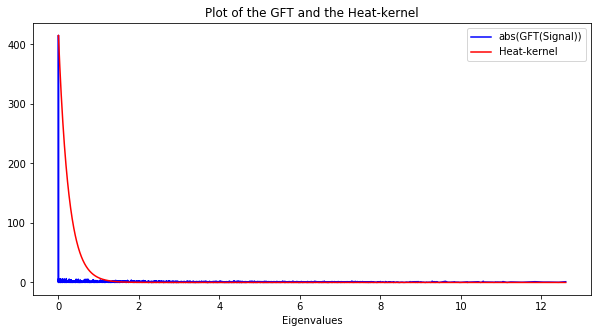

In [11]:
Signal_Informations(Cast_G, Base_signal, 50)

In [12]:
Graph_Cast_Nodes = pd.read_csv('Dataset_Exports/Cast/Graph_Cast_Nodes.csv')
Graph_Cast_Nodes.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0
0,0,0,0,NaN,110,38,7.0
1,1,1,1,NaN,141,15,7.0
2,2,2,2,NaN,76,15,6.0
3,3,3,3,NaN,191,16,8.0
4,4,4,4,NaN,132,15,6.0


In [13]:
Graph_Cast_Nodes_Test_1, Final_signal_Cast = Fill_Dataframe(Cast_G, Base_signal, Nodes_Test_1, Source_types_Test_1, 50, Graph_Cast_Nodes)
Graph_Cast_Nodes_Test_1.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0,diff_signal_node3,vote_average1,diff_signal_node5,vote_average2,diff_signal_node7,vote_average3,diff_signal_node33,vote_average4,diff_signal_node41,vote_average5,diff_signal_node169,vote_average6
0,0,0,0,NaN,110,38,7.0,4.0,7.0,2.0,7.0,8.0,8.0,6.0,8.0,1.0,8.0,1.0,8.0
1,1,1,1,NaN,141,15,7.0,4.0,7.0,2.0,7.0,8.0,8.0,6.0,8.0,1.0,8.0,1.0,8.0
2,2,2,2,NaN,76,15,6.0,4.0,6.0,2.0,6.0,8.0,7.0,6.0,7.0,1.0,7.0,1.0,7.0
3,3,3,3,NaN,191,16,8.0,4.0,10.0,2.0,10.0,8.0,10.0,6.0,10.0,1.0,10.0,1.0,10.0
4,4,4,4,NaN,132,15,6.0,4.0,6.0,2.0,6.0,8.0,7.0,6.0,7.0,1.0,7.0,1.0,7.0


In [14]:
Graph_Cast_Nodes_Test_1.to_csv('Dataset_Exports/Cast/Graph_Cast_Nodes_Test_1.csv')

### Adjacency - First role

In [15]:
First_Role_adjacency = np.loadtxt('Dataset_Exports/First_Role/Adjacency_First_Role_Weighted_Normalized.txt')

In [16]:
First_Role_G = pg.graphs.Graph(First_Role_adjacency)

2019-01-18 12:31:42,690:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4803 x 4803) may take some time.


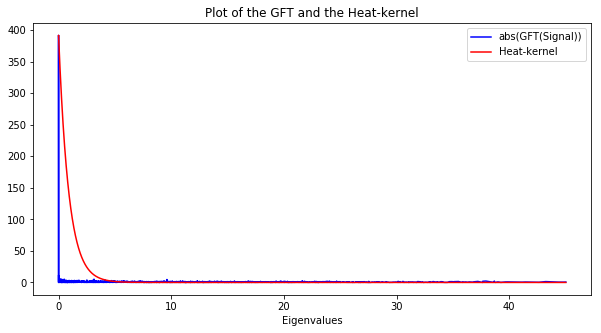

In [17]:
Signal_Informations(First_Role_G, Base_signal, 50)

In [18]:
Graph_First_Role_Nodes = pd.read_csv('Dataset_Exports/First_Role/Graph_First_Role_Nodes.csv')
Graph_First_Role_Nodes.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0
0,0,0,0,NaN,9,5,7.0
1,1,1,1,NaN,39,137,7.0
2,2,2,2,NaN,18,38,6.0
3,3,3,3,NaN,25,99,8.0
4,4,4,4,NaN,5,129,6.0


In [19]:
Graph_First_Role_Nodes_Test_1, Final_signal_First_Role = Fill_Dataframe(First_Role_G, Base_signal, Nodes_Test_1, Source_types_Test_1, 50, Graph_First_Role_Nodes)
Graph_First_Role_Nodes_Test_1.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0,diff_signal_node3,vote_average1,diff_signal_node5,vote_average2,diff_signal_node7,vote_average3,diff_signal_node33,vote_average4,diff_signal_node41,vote_average5,diff_signal_node169,vote_average6
0,0,0,0,NaN,9,5,7.0,3.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,7.0,0.0,7.0
1,1,1,1,NaN,39,137,7.0,2.0,7.0,1.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0,0.0,7.0
2,2,2,2,NaN,18,38,6.0,1.0,6.0,0.0,6.0,1.0,6.0,0.0,6.0,0.0,6.0,0.0,6.0
3,3,3,3,NaN,25,99,8.0,9.0,10.0,0.0,10.0,1.0,10.0,1.0,10.0,0.0,10.0,0.0,10.0
4,4,4,4,NaN,5,129,6.0,2.0,6.0,0.0,6.0,0.0,6.0,2.0,6.0,0.0,6.0,0.0,6.0


In [20]:
Graph_First_Role_Nodes_Test_1.to_csv('Dataset_Exports/First_Role/Graph_First_Role_Nodes_Test_1.csv')

### Adjacency - Genres

In [21]:
Genres_adjacency = np.loadtxt('Dataset_Exports/Genres/Adjacency_Genres_Weighted_Normalized.txt')

In [22]:
Genres_G = pg.graphs.Graph(Genres_adjacency)

2019-01-18 12:32:16,965:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4803 x 4803) may take some time.


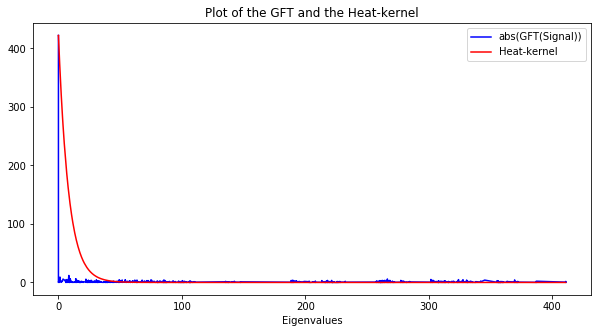

In [23]:
Signal_Informations(Genres_G, Base_signal, 50)

In [24]:
Graph_Genres_Nodes = pd.read_csv('Dataset_Exports/Genres/Graph_Genres_Nodes.csv')
Graph_Genres_Nodes.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0
0,0,0,0,NaN,309,6,7.0
1,1,1,1,NaN,149,7,7.0
2,2,2,2,NaN,295,6,6.0
3,3,3,3,NaN,320,6,8.0
4,4,4,4,NaN,329,6,6.0


In [25]:
Graph_Genres_Nodes_Test_1, Final_signal_Genres = Fill_Dataframe(Genres_G, Base_signal, Nodes_Test_1, Source_types_Test_1, 50, Graph_Genres_Nodes)
Graph_Genres_Nodes_Test_1.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0,diff_signal_node3,vote_average1,diff_signal_node5,vote_average2,diff_signal_node7,vote_average3,diff_signal_node33,vote_average4,diff_signal_node41,vote_average5,diff_signal_node169,vote_average6
0,0,0,0,NaN,309,6,7.0,10.0,9.0,0.0,9.0,10.0,9.0,5.0,9.0,5.0,9.0,10.0,9.0
1,1,1,1,NaN,149,7,7.0,5.0,7.0,0.0,7.0,6.0,7.0,10.0,8.0,10.0,9.0,6.0,9.0
2,2,2,2,NaN,295,6,6.0,10.0,8.0,0.0,8.0,10.0,9.0,5.0,9.0,5.0,9.0,10.0,9.0
3,3,3,3,NaN,320,6,8.0,10.0,10.0,0.0,10.0,10.0,10.0,4.0,10.0,4.0,10.0,10.0,10.0
4,4,4,4,NaN,329,6,6.0,10.0,8.0,0.0,8.0,10.0,9.0,5.0,9.0,5.0,9.0,10.0,9.0


In [26]:
Graph_Genres_Nodes_Test_1.to_csv('Dataset_Exports/Genres/Graph_Genres_Nodes_Test_1.csv')

### Adjacency - Crew

In [27]:
Crew_adjacency = np.loadtxt('Dataset_Exports/Crew/Adjacency_Crew_Weighted_Normalized.txt')

In [28]:
Crew_G = pg.graphs.Graph(Crew_adjacency)

2019-01-18 12:32:51,480:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4803 x 4803) may take some time.


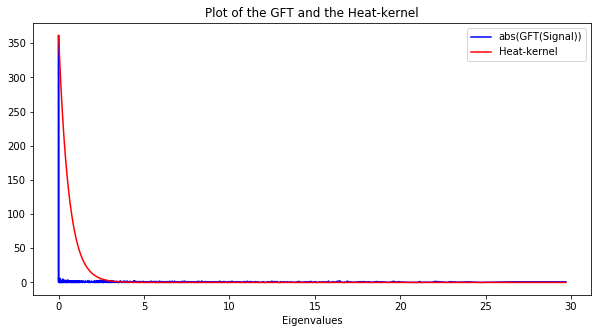

In [29]:
Signal_Informations(Crew_G, Base_signal, 50)

In [31]:
Graph_Crew_Nodes = pd.read_csv('Dataset_Exports/Crew/Graph_Crew_Nodes.csv')
Graph_Crew_Nodes.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0
0,0,0,0,NaN,51,60,7.0
1,1,1,1,NaN,70,16,7.0
2,2,2,2,NaN,32,92,6.0
3,3,3,3,NaN,91,16,8.0
4,4,4,4,NaN,8,92,6.0


In [32]:
Graph_Crew_Nodes_Test_1, Final_signal_Crew = Fill_Dataframe(Crew_G, Base_signal, Nodes_Test_1, Source_types_Test_1, 50, Graph_Crew_Nodes)
Graph_Crew_Nodes_Test_1.head()

,Unnamed: 0,Id,Label,timeset,degree,modularity_class,vote_average0,diff_signal_node3,vote_average1,diff_signal_node5,vote_average2,diff_signal_node7,vote_average3,diff_signal_node33,vote_average4,diff_signal_node41,vote_average5,diff_signal_node169,vote_average6
0,0,0,0,NaN,51,60,7.0,1.0,7.0,1.0,7.0,1.0,7.0,2.0,7.0,1.0,7.0,2.0,7.0
1,1,1,1,NaN,70,16,7.0,3.0,7.0,1.0,7.0,1.0,7.0,3.0,7.0,1.0,7.0,1.0,7.0
2,2,2,2,NaN,32,92,6.0,1.0,6.0,1.0,6.0,1.0,6.0,2.0,6.0,1.0,6.0,1.0,6.0
3,3,3,3,NaN,91,16,8.0,3.0,10.0,1.0,10.0,1.0,10.0,3.0,10.0,1.0,10.0,1.0,10.0
4,4,4,4,NaN,8,92,6.0,1.0,6.0,0.0,6.0,1.0,6.0,2.0,6.0,0.0,6.0,1.0,6.0


In [33]:
Graph_Crew_Nodes_Test_1.to_csv('Dataset_Exports/Crew/Graph_Crew_Nodes_Test_1.csv')

## 2 - Fusion of the results

Now that we have a new signal for each graph we want to see if there is a efficient way to consider all of them in a single signal. For that we are trying the mean terms by terms of the four signal we have.

We add those signals to the dataframe to see its representation on the different graphs.

In [34]:
Final_signal_Moy = (Final_signal_Cast + Final_signal_First_Role + Final_signal_Genres + Final_signal_Crew) / 4

In [37]:
Graph_Cast_Nodes_Test_1['vote_average_final'] = Bin_10_Signal(Final_signal_Moy)
Graph_First_Role_Nodes_Test_1['vote_average_final'] = Bin_10_Signal(Final_signal_Moy)
Graph_Genres_Nodes_Test_1['vote_average_final'] = Bin_10_Signal(Final_signal_Moy)
Graph_Crew_Nodes_Test_1['vote_average_final'] = Bin_10_Signal(Final_signal_Moy)

In [38]:
Graph_Cast_Nodes_Test_1.to_csv('Dataset_Exports/Cast/Graph_Cast_Nodes_Test_1.csv')
Graph_First_Role_Nodes_Test_1.to_csv('Dataset_Exports/First_Role/Graph_First_Role_Nodes_Test_1.csv')
Graph_Genres_Nodes_Test_1.to_csv('Dataset_Exports/Genres/Graph_Genres_Nodes_Test_1.csv')
Graph_Crew_Nodes_Test_1.to_csv('Dataset_Exports/Crew/Graph_Crew_Nodes_Test_1.csv')

## 3 - Conclusion

For this test based on superheroes movies we are quite pleased with the results. The modification on the different graph are correspondinf to what we expected.

Now we can see the suggestions for our user in regards on the final signal regrouping information from the four graphs.

In [102]:
# The movies suggested by using the mean signal:

Find_Movie(Final_signal_Moy, Nodes_Test_1)

You might want to take a look at the following movies:
- Stiff Upper Lips
- Dancer, Texas Pop. 81
- Me You and Five Bucks
- Little Big Top
- Sardaarji
- One Man's Hero
- The Prisoner of Zenda
- Seven Samurai
- Princess Mononoke
- The Shawshank Redemption
- There Goes My Baby
- Inception
- Scarface
- The Lord of the Rings: The Return of the King
- Interstellar
- Batman: The Dark Knight Returns, Part 2
- The Godfather
- Star Wars: Clone Wars: Volume 1
- The Lord of the Rings: The Fellowship of the Ring
- Guardians of the Galaxy


Among the suggestions of this model we can still find the preferred films of the majority, which makes sense as we haven’t placed a cold source to reduce their vote. But more importantly we can find some superheroes films.

However they are some parts of the process that needs to be clarified and completed. For instance it could be interesting to add other graphs built from new features. We could also search for other algorithms for our diffusion. We based it on the mean between a base signal and a diffused signal but there might be a more accurate way to see the influence of our vote in the base signal.
Moreover as we spoke about Netflix we could also try to had a collaborative filtering algorithm to this method to increase the number of vote to diffuse in a the graphs. It would take into account preferences of users that have the same taste as you.

As a conclusion for this project, it is possible to use diffusion on graphs to perform film suggestion.